In [6]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt

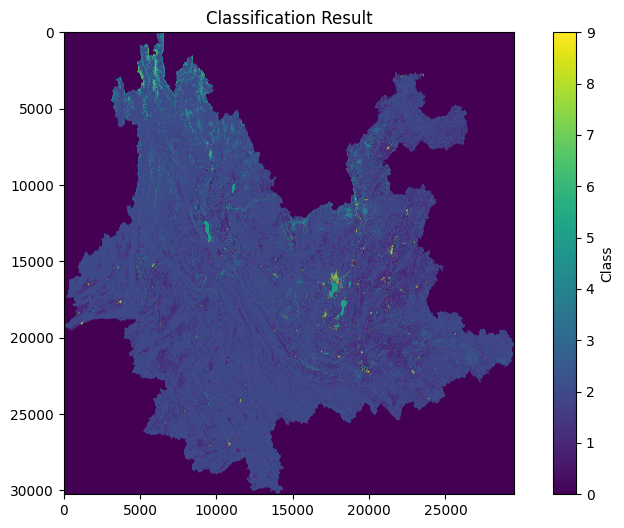

    region_id                       class_ids  \
0   156532300        [0, 1, 2, 3, 4, 5, 7, 8]   
1   156533400  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]   
2   156532500        [0, 1, 2, 3, 4, 5, 7, 8]   
3   156530100        [0, 1, 2, 3, 4, 5, 7, 8]   
4   156533100        [0, 1, 2, 3, 4, 5, 7, 8]   
5   156533300     [0, 1, 2, 3, 4, 5, 6, 7, 8]   
6   156530800        [0, 1, 2, 3, 4, 5, 7, 8]   
7   156530700     [0, 1, 2, 3, 4, 5, 6, 7, 8]   
8   156530900        [0, 1, 2, 3, 4, 5, 7, 8]   
9   156530400        [0, 1, 2, 3, 4, 5, 7, 8]   
10  156532600        [0, 1, 2, 3, 4, 5, 7, 8]   
11  156530300        [0, 1, 2, 3, 4, 5, 7, 8]   
12  156530600        [0, 1, 2, 3, 4, 5, 7, 8]   
13  156532900        [0, 1, 2, 3, 4, 5, 7, 8]   
14  156532800        [0, 1, 2, 3, 4, 5, 7, 8]   
15  156530500        [0, 1, 2, 3, 4, 5, 7, 8]   

                                         class_counts       area  
0   [18838801, 6714712, 21664924, 1031527, 1963266...   50420907  
1   [22383102, 533340, 18551455,

In [8]:

# 1. 读取分类结果 TIF 文件
tif_path = 'tif/CLCD_v01_2023_albert_yunnan.tif'  # 替换为你自己的 TIF 文件路径

# 使用 rasterio 打开栅格数据
with rasterio.open(tif_path) as src:
    # 读取栅格数据和元数据
    img_array = src.read(1)  # 读取第一波段的图像数据（假设是分类结果）
    transform = src.transform
    crs = src.crs

    # 2. 读取行政区矢量文件（Shapefile）
    shapefile_path = 'shape/YNshiji.shp'  # 替换为你自己的 Shapefile 文件路径
    gdf = gpd.read_file(shapefile_path)

    # 确保矢量数据与栅格数据的坐标系一致
    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)

    # 3. 计算分区统计（Zonal Statistics）
    # 将栅格图像裁剪到每个行政区的区域
    zonal_stats = []

    for idx, region in gdf.iterrows():
        # 获取每个行政区的几何信息（转换为 GeoJSON）
        geometry = [mapping(region.geometry)]

        # 使用 rasterio 的 mask 方法裁剪栅格数据
        out_image, out_transform = mask(src, geometry, crop=True)
        out_image = out_image[0]  # 取出第一波段（分类数据）

        # 计算该区域内的分类面积统计
        unique_classes, counts = np.unique(out_image, return_counts=True)

        # 存储该区域的统计结果
        zonal_stats.append({
            'region_id': region['gb'],  # 假设每个区域有一个 'id' 字段
            'class_ids': unique_classes.tolist(),
            'class_counts': counts.tolist(),
            'area': out_image.size,  # 统计区域的像元数量
        })

    # 将统计结果转换为 DataFrame
    import pandas as pd
    zonal_stats_df = pd.DataFrame(zonal_stats)

    # 4. 可视化结果（选做）
    plt.figure(figsize=(10, 6))
    plt.imshow(img_array, cmap='viridis')  # 显示分类结果图像
    plt.colorbar(label='Class')
    plt.title('Classification Result')
    plt.show()

    # 5. 打印分区统计结果
    print(zonal_stats_df)

    # 6. 导出结果到 CSV 文件
    zonal_stats_df.to_csv('zonal_statistics.csv', index=False)